In [10]:
# Import necessary libraries
from fredapi import Fred
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import warnings

# Disable warnings
warnings.filterwarnings('ignore')

           Date  Interest Rate
9914 2000-01-03           6.58
9915 2000-01-04           6.49
9916 2000-01-05           6.62
9917 2000-01-06           6.57
9918 2000-01-07           6.52


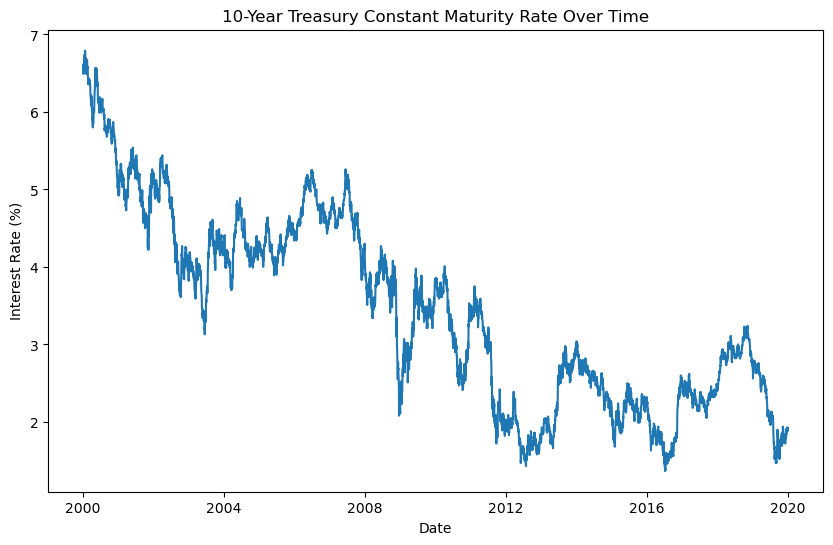

In [11]:
# Initialize Fred API with your API key
fred = Fred(api_key='dc7c3ec781759add86587b96ae2c8b0a')

# Fetch U.S. 10-Year Treasury Constant Maturity Rate (DGS10)
data = fred.get_series('DGS10')

# Convert to a DataFrame and reset the index
data = pd.DataFrame(data, columns=['Interest Rate'])
data.index.name = 'Date'
data.reset_index(inplace=True)

# Convert the 'Date' column to datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Filter data from 2010 to 2020
data = data[(data['Date'] >= '2000-01-01') & (data['Date'] <= '2020-01-01')]

# Drop rows with missing values
data.dropna(inplace=True)

# Display first few rows of the filtered data
print(data.head())

plt.figure(figsize=(10, 6))
plt.plot(data['Date'], data['Interest Rate'])
plt.title('10-Year Treasury Constant Maturity Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Interest Rate (%)')
plt.show()

We are using the seasonal_decompose function, which breaks down the time series into three components:

Trend: The long-term progression of the series.

Seasonality: The repeating short-term cycle in the data.

Residual: The remainder after removing the trend and seasonality from the data.

Index(['index', 'Date', 'Interest Rate'], dtype='object')


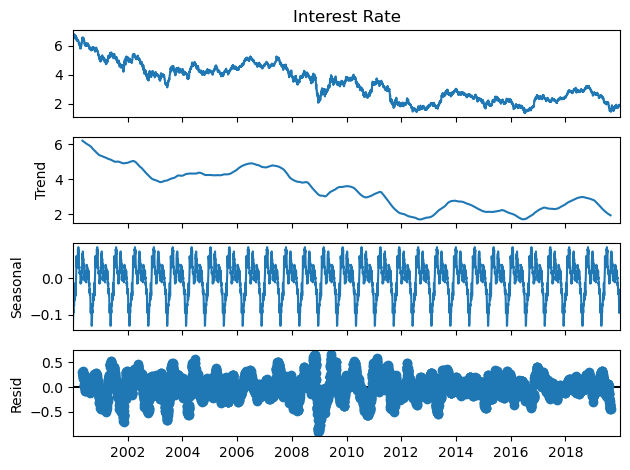

In [12]:
# Reset the index to bring back the 'Date' column if it was the index
data.reset_index(inplace=True)
print(data.columns)

# Set the 'Date' column as the index and ensure it's sorted
data.set_index('Date', inplace=True)
data = data.asfreq('D')  # Set frequency as daily for the decomposition
data = data.fillna(method='ffill')  # Fill any missing values

# Perform seasonal decomposition using a yearly pattern (252 trading days)
decomposition = seasonal_decompose(data['Interest Rate'], model='additive', period=252)

# Plot the decomposed components: trend, seasonal, and residual
decomposition.plot()
plt.tight_layout()
plt.show()


**Observed**: The original time series of the DGS10, showing interest rate on a gradual decline from around 6% in the early 2000s to around 2-3% post-2010, with minor fluctuations.

**Trend**: The trend shows the long-term movement of the interest rate. The curve illustrates a decreasing trend over the years, with notable drops during economic crises (e.g., around 2008). There are slow oscillations, but the overall pattern shows a decline.

**Seasonal**: The seasonal component show a strong and consistent seasonal pattern with annual cycles, suggesting regular fluctuations in interest rates due to predictable economic or policy factors.

**Residual**: The remaining variability after removing the trend and seasonal components. The residuals seem to show more variability between 2008-2010, likely due to increased volatility around the global financial crisis.

### Data stationarity

ADF Statistic: -2.351872037208759
p-value: 0.15578323233432478


<Figure size 1000x600 with 0 Axes>

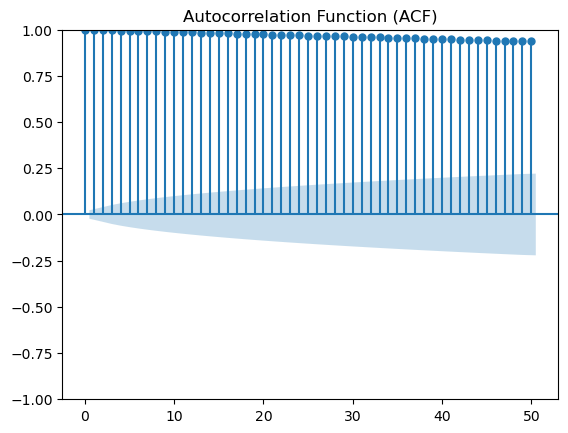

<Figure size 1000x600 with 0 Axes>

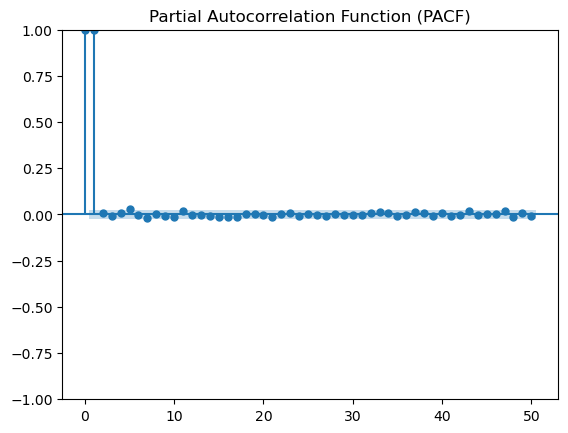

In [13]:
# ADF stationarity test
adf_result = adfuller(data['Interest Rate'].dropna())
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')

# Plot the ACF for the original data
plt.figure(figsize=(10, 6))
plot_acf(data['Interest Rate'], lags=50)
plt.title('Autocorrelation Function (ACF)')
plt.show()

# Plot the PACF for the original data
plt.figure(figsize=(10, 6))
plot_pacf(data['Interest Rate'], lags=50)
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

**ADF Statistic**: The more negative the ADF statistic, the stronger the rejection of the null hypothesis, which is that the time series has a unit root (i.e., it's non-stationary). In this case, the ADF statistic is not low enough (relative to critical values) to reject the null hypothesis of non-stationarity.

**p-value**: The p-value is higher than the typical significance levels (0.05 or 0.01), meaning we fail to reject the null hypothesis, implying that the series is likely *non-stationary*.

The ADF statistic and p-value suggest that the time series data is **non-stationary**.

### The Autocorrelation Function (ACF) 

The **ACF** shows strong autocorrelation at almost every lag, suggesting that the time series is highly persistent. This usually indicates that the data may not be stationary, and it shows the influence of previous values over future ones over a large number of time lags.
All the lags are outside of the confidence interval (the shaded region), indicating significant autocorrelation for those lags. In stationary time series, the autocorrelation values tend to decrease as the lag increases. In this case, the autocorrelation remains high across all lags suggests that the series has some underlying trend or pattern that needs to be removed before it can be modeled effectively. 

### Partial Autocorrelation Function (PACF) 

The **PACF** plot has significant spikes at lag 1 and lag 2, indicating that once the influence of these early lags is removed, the remaining lags are mostly uncorrelated.
This suggests that there may be a strong relationship with the first couple of previous time points (lags), but the influence of longer lags is less important.

#### Summary

- The ADF test's higher p-value (0.155) and persistent autocorrelations in the ACF plot confirm that the data is **non-stationary** and pplying differencing (d=1) will likely help address this and make the data stationary.

- The data shows a clear **downward trend over time**, as seen in the original time series plot (in the previous decomposition image). Differencing should help remove this trend. This kind of trend suggests that the interest rate has generally declined, possibly driven by macroeconomic factors, regulatory changes, or other external events.

- From the seasonality component in the decomposition plot, it appears that the time series has annual seasonality. There are consistent periodic fluctuations that could correspond to yearly economic cycles or other recurring factors affecting the interest rate.
The presence of this seasonal pattern suggests that if a forecasting model like **ARIMA** to be used, it must be accounted for seasonality explicitly, possibly using **SARIMA (Seasonal ARIMA)** or **Prophet**.

- The PACF plot suggests that only the first two lags are significantly correlated with the series. This means that most of the predictive power comes from the immediate previous values (lag 1 or lag 2). This could imply that an **AR(1)** or **AR(2)** model (AutoRegressive with lag 1 or 2) might be a good starting point for modeling this data. Further autocorrelations diminish quickly after lag 2, suggesting that beyond a short-term memory, the series is less predictable from earlier data points.

- The high and **persistent autocorrelation suggests** that the time series needs to be **differenced to make it stationary**. This involves subtracting the previous value from the current value in the series. 
Differencing is done to remove trends and seasonality from the data, making it stationary. The first differencing (d=1) means subtracting each observation from the previous one.

